<a href="https://colab.research.google.com/github/thmspfffr/Voice-classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 99% 426M/429M [00:16<00:00, 22.0MB/s]
100% 429M/429M [00:16<00:00, 26.6MB/s]


In [5]:
! mkdir data
! mkdir data/ravdess
! mv ravdess-emotional-speech-audio.zip data/ravdess


In [10]:
cd data/ravdess


/content/data/ravdess


In [ ]:
! unzip ravdess-emotional-speech-audio.zip

Actual code begins here

In [81]:
import numpy as np 
import pandas as pd 
from glob import glob
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
# Vocal channel (01 = speech, 02 = song).
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

audios = glob('*/*.wav')

mod = []; voc_chan = []; emo = []; emo_intens = []; repet = []; actor = []
for i in range(0,len(audios)):
    
    mod.append(int(audios[i].split('/')[-1][1]))
    voc_chan.append(int(audios[i].split('/')[-1][4]))
    emo.append(int(audios[i].split('/')[-1][7]))
    emo_intens.append(int(audios[i].split('/')[-1][10]))
    repet.append(int(audios[i].split('/')[-1][13]))
    actor.append(int(audios[i].split('/')[-1][18:19]))
    
    
# MINIMUM LENGTH: 64745 samples    
# lens = len(audios)*[None] 
# for i in range(0,len(audios)):
#     print(i,end=' ')
#     lens[i]=librosa.load(audios[i])[0].shape[0]
# min_length = min(lens)
min_length = 64745

d = {'Modality': mod, 'Channel': voc_chan, 'Emotion': emo, 'Emotional_Intensity': emo_intens, 'Repetition': repet, 'Actor': actor, 'Filename': audios}
df = pd.DataFrame(data=d)

del mod, voc_chan, emo, emo_intens, actor, repet

Two functions for processing the audio data

In [54]:
def convert_to_melspec(path):
    audio_data, sr = librosa.load(path)
    idx = int(np.floor((audio_data.shape[0]-min_length)/2))
    audio_data = audio_data[idx:-idx]
    Sxx  = librosa.feature.melspectrogram(y=audio_data, sr=sr,n_fft =2046,win_length=512,hop_length=256)
    S_dB = librosa.power_to_db(Sxx, ref=np.max)
    
    return S_dB

def zscore(data):
    m = data.reshape(np.prod(data.shape)).mean()
    s = data.reshape(np.prod(data.shape)).std()
    data=(data-m)/s
    return data
    
data=np.zeros([128,253,len(audios)])
for i in range(0,len(audios)):
    print(i,end = ' ')
    data[:,:,i]=convert_to_melspec(audios[i])

data = np.transpose(data, (2,1,0))

X = zscore(data)
y = df['Emotion']-1

# del data



Plot the result

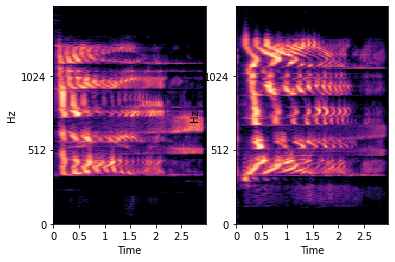

In [60]:
audio_data, sr = librosa.load(audios[0])

import librosa.display

fig, (ax1,ax2) = plt.subplots(1,2)

img = librosa.display.specshow(data[0,:,:], x_axis='time', y_axis='mel', sr=sr, fmax=2000, ax=ax1)
img = librosa.display.specshow(data[1000,:,:], x_axis='time', y_axis='mel', sr=sr, fmax=2000, ax=ax2)

### First approach: regular neural network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)

    
model = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(8)
])

# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=5,
#   decay_rate=0.8,
#   staircase=False)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test),batch_size=32,callbacks=[callback])

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


Text(0.5, 1.0, 'Regular NN')

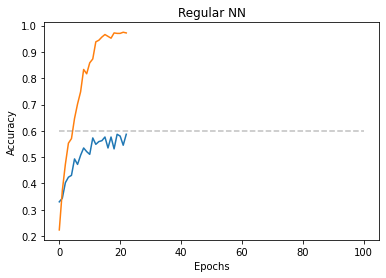

In [64]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot([0,100],[0.6,0.6],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Regular NN')

Model very **quickly overfits**

In [ ]:
# CONVOLUTIONAL NEURAL NETWORK 
# ---------------------

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)

y_test = tf.stack(y_test)
y_train = tf.stack(y_train)

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

model = models.Sequential() 
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2],1))) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(32, (2, 2), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((3, 3))) 
model.add(layers.Conv2D(256, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((3, 3))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(layers.Flatten()) 
model.add(layers.Dense(8,activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test),batch_size=32,callbacks=[callback])

Text(0, 0.5, 'Accuracy')

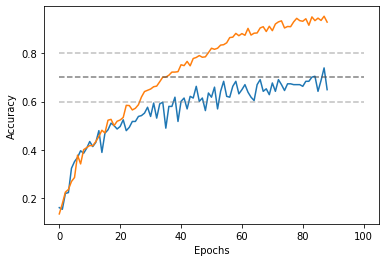

In [72]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot([0,100],[0.6,0.6],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)
plt.plot([0,100],[0.7,0.7],linestyle='--',color=[0.3, 0.3, 0.3],alpha=0.7)
plt.plot([0,100],[0.8,0.8],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

The model seems to hit a performance ceiling at a **validation accuracy of around 70%**. Not too bad but also not quite competetive. SOTA architectures reach around 80% classification accuracy on this dataset. It is also evident that the model is overfitting quite a bit. Performance of the CNN is a bit better than the performance of the regular NN, but the difference isn't all too big. Main problem likely is the low number of samples (N=1440). 

---



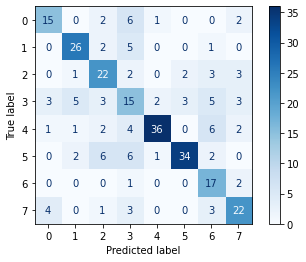

In [95]:
import matplotlib.cm
from sklearn.metrics import ConfusionMatrixDisplay

cmap = matplotlib.cm.get_cmap('Blues')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)